# Simple FFS scheme

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from dask import delayed
from random import choice

## Solving the Langevin Equation in a double-well potential

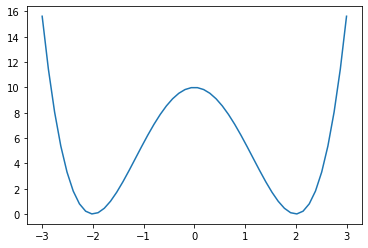

In [60]:
# define a double well potential
def double_well_potential(x, k=2.5, a=2):
    energy = 0.25*k*((x-a)**2) * ((x+a)**2)
    force = -k*x*(x-a)*(x+a)
    return energy, force

# plot the potential
interval = np.linspace(-3, 3)
plt.plot(interval, double_well_potential(interval)[0])
plt.show()

In [61]:
dt = 1e-3
save_interval = 0.1
m = 1
gamma = 1
kBT = 1

def update_position(x, v):
    return x + v * dt

def update_velocity(v, F):
    return v + F/m * dt

def update_random_velocity(v):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
    return c1*v + R*c2

def solve(x_start, v_start, t_max):
    x = x_start
    v = 0
    t = 0
    save_times = [0]
    positions = [x]
    velocities = [v]
    last_save = 0

    while t < t_max:

        # B
        energy, force = double_well_potential(x)
        v = update_velocity(v, force)

        # A
        x = update_position(x, v)

        #O
        v = update_random_velocity(v)

        #A
        x = update_position(x, v)

        #B
        v = update_velocity(v, force)

        t = t + dt

        if t - last_save >= save_interval:
            save_times.append(t)
            positions.append(x)
            velocities.append(v)

    return save_times, positions, velocities

In [62]:
times, pos, vel = solve(-2, 0, 100)

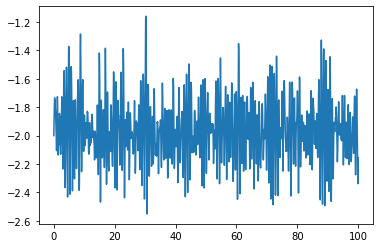

In [63]:
plt.plot(times, pos)

## FFS implementation

### Sampling the initial state

In [64]:
# interfaces
lambdas = np.append(np.linspace(-1.8, 1, 20), np.linspace(-1.2, 0, 5))
lambdas = np.append(lambdas, [1, 2])
print(len(lambdas))
print(lambdas)

ns = np.repeat(1e5, 10)
ns = np.append(ns, np.repeat(1e4, 16)).flatten()
print(len(ns))
print(ns)

27
[-1.8        -1.65263158 -1.50526316 -1.35789474 -1.21052632 -1.06315789
 -0.91578947 -0.76842105 -0.62105263 -0.47368421 -0.32631579 -0.17894737
 -0.03157895  0.11578947  0.26315789  0.41052632  0.55789474  0.70526316
  0.85263158  1.         -1.2        -0.9        -0.6        -0.3
  0.          1.          2.        ]
26
[100000. 100000. 100000. 100000. 100000. 100000. 100000. 100000. 100000.
 100000.  10000.  10000.  10000.  10000.  10000.  10000.  10000.  10000.
  10000.  10000.  10000.  10000.  10000.  10000.  10000.  10000.]


In [65]:
def solve_ffs_start(n_max, x_start, v_start):
    x = x_start
    v = 0
    t = 0
    n = 0
    saved_states = list()

    while n < n_max:
        prev_x = [x][0]

        # B
        energy, force = double_well_potential(x)
        v = update_velocity(v, force)

        # A
        x = update_position(x, v)

        #O
        v = update_random_velocity(v)

        #A
        x = update_position(x, v)

        #B
        v = update_velocity(v, force)

        t = t + dt

        if x >= lambdas[0] and prev_x < lambdas[0]:
            saved_states.append([x, v])
            n += 1
    
    return saved_states, t
    

In [66]:
first_crossing_states, t_sim = solve_ffs_start(1e2, -2, 0)

### Sampling subsequent interface crossings

In [67]:
def solve_ffs(x_start, v_start, x_max, x_min):
    x = x_start
    v = v_start
    t = 0
    result = None

    while x > x_min:

        # B
        energy, force = double_well_potential(x)
        v = update_velocity(v, force)

        # A
        x = update_position(x, v)

        #O
        v = update_random_velocity(v)

        #A
        x = update_position(x, v)

        #B
        v = update_velocity(v, force)

        t = t + dt

        if x >= x_max:
            result = [x, v]
            break

    return result

In [68]:
def ffs_step(n, initial_states, x_min, x_max):

    final_states = []
    for i in range(n):
        x_start, v_start = choice(initial_states)
        final_state = solve_ffs(x_start, v_start, x_max, x_min)
        final_states.append(final_state)
   
    return [item for item in final_states if item is not None]

In [69]:
crossing_probs = []
states = first_crossing_states
for i in range(1, len(lambdas)):
    n = int(ns[i])
    states = ffs_step(n, states, lambdas[0], lambdas[i])
    crossing_prob = len(states)/n
    crossing_probs.append(crossing_prob)
    print(f"{len(states)} trajectories reached {lambdas[i]}")

59335 trajectories reached -1.6526315789473685
46529 trajectories reached -1.5052631578947369
44950 trajectories reached -1.3578947368421055
41306 trajectories reached -1.210526315789474
32605 trajectories reached -1.0631578947368423
25550 trajectories reached -0.9157894736842107
24037 trajectories reached -0.7684210526315791
25712 trajectories reached -0.6210526315789475
32056 trajectories reached -0.47368421052631593
4331 trajectories reached -0.32631578947368434
5896 trajectories reached -0.17894736842105274
7764 trajectories reached -0.03157894736842137
9436 trajectories reached 0.11578947368421022
9957 trajectories reached 0.2631578947368418
9999 trajectories reached 0.4105263157894734
10000 trajectories reached 0.557894736842105
10000 trajectories reached 0.7052631578947366
10000 trajectories reached 0.8526315789473682
10000 trajectories reached 1.0
10000 trajectories reached -1.2
10000 trajectories reached -0.8999999999999999
10000 trajectories reached -0.6
10000 trajectories re

IndexError: index 26 is out of bounds for axis 0 with size 26

In [70]:
crossing_probs

[0.59335,
 0.46529,
 0.4495,
 0.41306,
 0.32605,
 0.2555,
 0.24037,
 0.25712,
 0.32056,
 0.4331,
 0.5896,
 0.7764,
 0.9436,
 0.9957,
 0.9999,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [71]:
first_flux = len(first_crossing_states)/t_sim
k = first_flux * np.product(crossing_probs)
k

1.695246523771087e-05